In [1]:
from mesh4d import utils

landmarks = utils.load_pkl_object('output/transform/fast_transform.pkl')
landmarks.to_array()[0].shape

(5, 12, 3)

## Euclidean measurements

> Zhang, L. Y., Yick, K. L., Yue, M. J., Yip, J., & Ng, S. P. (2023). An exploratory study of dynamic foot shape measurements with 4D scanning system. Scientific Reports, 13(1), 8628.

In [2]:
def get(landmarks, marker_name, coord):
    coord2idx = {
        'x': 0,
        'y': 1,
        'z': 2
    }
    return landmarks.markers[marker_name].coord[coord2idx[coord]]

In [3]:
import numpy as np

metric = {}

metric['FL'] = ['foot length'] + list(np.abs(get(landmarks, 'P1', 'y') - get(landmarks, 'P10', 'y')))
metric['MBL'] = ['medial ball length'] + list(np.abs(get(landmarks, 'P4', 'y') - get(landmarks, 'P10', 'y')))
metric['LBL'] = ['lateral ball length'] + list(np.abs(get(landmarks, 'P5', 'y') - get(landmarks, 'P10', 'y')))
metric['ABW'] = ['anatomical ball width'] + list(np.sqrt(
    (get(landmarks, 'P4', 'y') - get(landmarks, 'P3', 'y'))**2
    + (get(landmarks, 'P4', 'x') - get(landmarks, 'P3', 'x'))**2
    ))
metric['OBW'] = ['orthogonal ball width'] + list(np.abs(get(landmarks, 'P4', 'x') - get(landmarks, 'P3', 'x')))
metric['OHW'] = ['orthogonal heel width'] + list(np.abs(get(landmarks, 'P9', 'x') - get(landmarks, 'P8', 'x')))
metric['BH'] = ['ball heigh'] + list(np.abs(get(landmarks, 'P6', 'z')))
metric['IH'] = ['instep height'] + list(np.abs(get(landmarks, 'P7', 'z')))

In [4]:
import pandas as pd

df = pd.DataFrame(metric, index=['description'] + [f'frame{idx}' for idx in range(len(landmarks.to_array()[0]))])
df

,FL,MBL,LBL,ABW,OBW,OHW,BH,IH
description,foot length,medial ball length,lateral ball length,anatomical ball width,orthogonal ball width,orthogonal heel width,ball heigh,instep height
frame0,9.438303,36.844064,45.787799,84.808372,1.562493,4.246227,33.190416,46.391936
frame1,8.651849,37.763568,49.8433,93.012446,3.082296,5.162034,36.835374,53.541192
frame2,11.2752,32.129279,56.622528,93.468188,1.151417,12.351665,33.808143,47.29867
frame3,11.202253,31.691739,58.005154,91.542056,0.723595,3.241977,32.514522,43.742458
frame4,13.365737,29.528376,56.300205,86.982529,0.937706,9.352607,27.930671,40.848288


<Axes: >

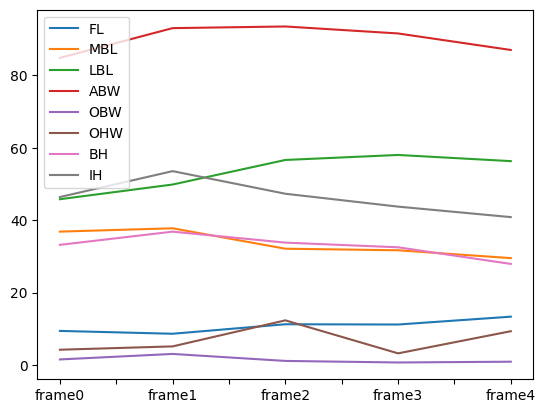

In [5]:
df['frame0':'frame4'].plot()

## Geodesic measurements

### Data loading and reorientation

In [6]:
from mesh4d import obj3d

mesh_ls, _ = obj3d.load_mesh_series(
    folder='/Users/knpob/Territory/Kolmo/data/DynaFootLite/Fast',
    start=0,
    stride=1,
    end=4,
    load_texture=False,
)

[====================] 100.0% loading: /Users/knpob/Territory/Kolmo/data/DynaFootLite/Fast/Sub05_Fast_L1_102_143.000031.obj


In [7]:
from mesh4d import utils

axes_ls = utils.load_pkl_object('output/axes/fast_axes.pkl')
axes_ls

[{'mean': array([ -19.35173802, -110.94776322,   74.37263339]),
  'axes': array([[ 0.19903776, -0.14165672,  0.96969962],
         [-0.92427362, -0.3560279 ,  0.13770409],
         [-0.32573341,  0.92367608,  0.20179257]]),
  'stds': array([80.52793393, 32.42319736, 23.02691387])},
 {'mean': array([ -22.42135458, -127.11639593,   64.8034745 ]),
  'axes': array([[ 0.20051408,  0.02323243,  0.97941531],
         [-0.94901286, -0.24361279,  0.2000685 ],
         [-0.24324617,  0.96959428,  0.02679992]]),
  'stds': array([83.00320047, 33.24360171, 25.43468768])},
 {'mean': array([ -19.68341878, -132.24813197,   59.90065043]),
  'axes': array([[ 0.17702965,  0.07655359,  0.98122375],
         [-0.95378109, -0.23262645,  0.19022768],
         [-0.24282121,  0.9695486 , -0.03183359]]),
  'stds': array([81.78863716, 34.32191984, 23.11622719])},
 {'mean': array([ -18.23912556, -128.04792848,   59.43811265]),
  'axes': array([[ 0.2030801 ,  0.13585729,  0.96969133],
         [-0.94794561, -0.220

In [8]:
# helper functions
def coord_cartesian2homo(vertices):
    shape = list(vertices.shape)
    shape[1] += 1

    vertices_homo = np.ones(shape)
    vertices_homo[:, :3] = vertices
    return vertices_homo

def coord_homo2cartesian(vertices_homo):
    return vertices_homo[:, :3] / vertices_homo[:, [-1]]

def transformation_matrix2global(axes, origin):
    """e(i) -> a_i + t"""
    matrix = np.eye(4)
    matrix[:3, :3] = axes.T
    matrix[:3, 3] = origin
    
    return matrix

def transformation_matrix2local(axes, origin):
    """a_i + t -> e(i)"""
    matrix2golbal = transformation_matrix2global(axes, origin)
    return np.linalg.inv(matrix2golbal)

def transform(matrix, vertices):
    vertices_homo = coord_cartesian2homo(vertices)
    vertices_transform = (matrix @ vertices_homo.T).T
    return coord_homo2cartesian(vertices_transform)

In [9]:
mesh_transform_ls = []

for idx in range(len(mesh_ls)):
    matrix = transformation_matrix2local(axes_ls[idx]['axes'], axes_ls[idx]['mean'])
    mesh_transform_ls.append(mesh_ls[idx].transform(matrix, inplace=False))

### Remove disconnected parts

In [92]:
mesh_fix_ls = []

for mesh in mesh_transform_ls:
    clean = mesh.clean()
    bodies = clean.split_bodies()

    point_nums = [len(body.points) for body in bodies]
    max_index = point_nums.index(max(point_nums))
    mesh_fix_ls.append(bodies[max_index].extract_surface())

In [93]:
import pyvista as pv

# plot example
scene = pv.Plotter()
color_ls = ['r', 'g', 'b', 'y', 'm', 'c']

for idx, body in enumerate(bodies):
    scene.add_mesh(body.extract_surface(), opacity=0.5, color=color_ls[idx])

scene.show()

Widget(value="<iframe src='http://localhost:64614/index.html?ui=P_0x7fb66965f4c0_19&reconnect=auto' style='wid…

### Circumference calculation

In [96]:
from mesh4d.analyse import measure

cir_ls = []

for frame in range(len(mesh_fix_ls)):
    p4 = landmarks.markers['P4'].coord[:, frame]
    p5 = landmarks.markers['P5'].coord[:, frame]
    id4 = mesh_fix_ls[frame].find_closest_point(p4)
    id5 = mesh_fix_ls[frame].find_closest_point(p5)

    # extract geodesic path
    path = mesh_fix_ls[frame].geodesic(id4, id5)

    # estimate circumference plane
    norm, center = measure.estimate_plane_from_points(path.points)
    mesh_clip = mesh_fix_ls[frame].clip(norm, origin=center, invert=True)

    # calculate circumference
    boundary = mesh_clip.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
    cir_ls.append(boundary.length)

In [98]:
df['ABG'] = ['anatomical ball girth'] + cir_ls
df

,FL,MBL,LBL,ABW,OBW,OHW,BH,IH,ABG
description,foot length,medial ball length,lateral ball length,anatomical ball width,orthogonal ball width,orthogonal heel width,ball heigh,instep height,anatomical ball girth
frame0,9.438303,36.844064,45.787799,84.808372,1.562493,4.246227,33.190416,46.391936,132.788938
frame1,8.651849,37.763568,49.8433,93.012446,3.082296,5.162034,36.835374,53.541192,126.761068
frame2,11.2752,32.129279,56.622528,93.468188,1.151417,12.351665,33.808143,47.29867,350.22798
frame3,11.202253,31.691739,58.005154,91.542056,0.723595,3.241977,32.514522,43.742458,130.161966
frame4,13.365737,29.528376,56.300205,86.982529,0.937706,9.352607,27.930671,40.848288,122.91516


In [105]:
scene = pv.Plotter()
scene.add_mesh(mesh_fix_ls[frame], opacity=0.5, color='white')
# scene.add_mesh(path, line_width=5, color='k')
scene.add_mesh(mesh_clip, opacity=0.5, color='r')
scene.add_mesh(boundary, color='b')
scene.show()

Widget(value="<iframe src='http://localhost:64614/index.html?ui=P_0x7fb6cb2fe5e0_26&reconnect=auto' style='wid…

###  and length

In [89]:



mesh_clip.plot()

Widget(value="<iframe src='http://localhost:64614/index.html?ui=P_0x7fb67baf9bb0_18&reconnect=auto' style='wid…